# DeepHack course on RL. Assignment 3.
# Dynamic Programming

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
from gym import wrappers
import numpy as np

import gym
%matplotlib inline

## FrozenLake8x8-v0
https://gym.openai.com/envs/FrozenLake-v0

Creating an environment

In [2]:
env = gym.make('FrozenLake8x8-v0')

INFO:gym.envs.registration:Making new env: FrozenLake8x8-v0
[2017-01-02 20:52:21,643] Making new env: FrozenLake8x8-v0


In [3]:
observation = env.reset()

In [4]:
env.render(mode='human')

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



This is how the board looks like. The board is fixed. We start at 'S' and need to get to 'G' avoiding 'H'.

In [5]:
env.action_space

Discrete(4)

Action space consists of going up, down, left or right

- LEFT = 0
- DOWN = 1
- RIGHT = 2
- UP = 3

We can't go outside the board. For example if we try to go left from the leftmost column, we don't move. 

In [6]:
observation, reward, done, info = env.step(action=1)
env.render(mode='human')

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)


We don't fully control the movement. We only select, where we don't want to go, and the direction is then selected with equal probability across the other three. 

The environment provides a matrix of transition probabilities P.

$P[s][a] = [(\mbox{probability, nextstate, reward, done}), ...]$, where s is current state and a is the action taken.

In [7]:
s, a = 23, 0
transition_probs = env.P[23][0]
print('P[', np.unravel_index(s, (8,8)), '][', a,'] =')
[(p, np.unravel_index(s1, (8,8))) for p,s1,_,_ in transition_probs]

P[ (2, 7) ][ 0 ] =


[(0.3333333333333333, (1, 7)),
 (0.3333333333333333, (2, 6)),
 (0.3333333333333333, (3, 7))]

Let's construct a transition probability matrix for a policy, that chooses a random action at each moment. We will specify a policy with a matrix of size n_states x n_actions. 

$$\mbox{policy}[s][a] = \pi(a|s)$$

In [8]:
random_policy = np.ones((env.nS, env.nA))/4

In [9]:
def mk_transition_matrix(policy, environment):
    state_number = environment.nS
    transition_probs = np.zeros((state_number, state_number))
    reward_vec = np.zeros((environment.nS, 1))
    for state0, actions in environment.P.items():
        for action, transitions in actions.items():
            for transition in transitions:
                probability, state1, reward, _ = transition
                transition_probs[state0, state1] += policy[state0, action] * probability
                reward_vec[state0] += policy[state0, action] * probability * reward
    return transition_probs, reward_vec

In [10]:
tr_probs, r_vec = mk_transition_matrix(random_policy, env)

reward_vec contains the expected reward for each state.

In [11]:
r_vec.reshape(8, 8)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  ]])

Let's compute the value function for this policy. In order to do so, we solve the Bellman's eqation with the simple iteration method.

In [12]:
eps = 1e-4
v = np.zeros_like(r_vec)
for i in range(100):
    v_new = tr_probs.dot(v) + r_vec
    if np.max(np.abs(v - v_new)) < eps:
        break
    v = v_new

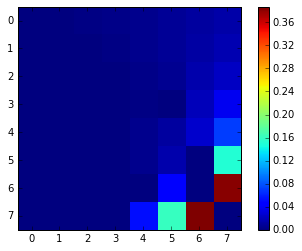

In [13]:
plt.imshow(v.reshape(8, 8), interpolation='nearest')
plt.colorbar()

### Policy Iteration Method
Policy iteration method iteratively approximates the optimal policy. On each iteration it 

- For a fixed policy finds it's value function
- Improves the policy, making it greedy wrt the current value function

We've already seen, how to evaluate the value function of a policy.

In [14]:
# Policy evaluation
def eval_policy(policy, environment, maxiter=100, eps=1e-4):
    tr_probs, r_vec = mk_transition_matrix(policy, environment)

    # Solving the linear equation system
    v = np.zeros_like(r_vec)
    for i in range(maxiter):
        v_new = tr_probs.dot(v) + r_vec
        if np.max(np.abs(v - v_new)) < eps:
            break
        v = v_new
    return v

In [15]:
v_policy = eval_policy(random_policy, env)

In order to improve the policy, we make it greedy wrt the current value function. This means, that for each state we (deterministically) select the action, that yields the highest expected return.
$$\hat\pi(s) = \arg \max\limits_{a} q_{\pi}(s, a) = \arg \max\limits_{a} \sum\limits_{s'} p(s' | s, a) \left(r(s, a, s') + v(s')\right)$$

We will need a function, that computes the action value function for the given policy
$$q_{\pi}(s, a) = \sum\limits_{s'} p(s' | s, a) \left(r(s, a, s') + v(s')\right)$$

In [16]:
def action_value(value_function, environment):
    q = np.zeros((environment.nS, environment.nA))
    for state0, actions in environment.P.items():
        for action, transitions in actions.items():
            for transition in transitions:
                probability, state1, reward, _ = transition
                q[state0, action] += probability * (reward + value_function[state1])
    return q

In [17]:
action_values = action_value(v_policy, env)

Now we can define the policy improvement function

In [18]:
# Policy improvement
def improve_policy(value_function, environment):
    action_values = action_value(value_function, environment)
    new_policy = np.zeros((environment.nS, environment.nA))
    new_policy[np.arange(environment.nS), np.argmax(action_values, axis=1)] = 1
    return new_policy

Finally, we can define the policy iteration method

In [19]:
def policy_iteration(environment, maxiter=100):
    value_function = np.zeros((environment.nS))
    policy = np.ones((environment.nS, environment.nA))/environment.nA
    for i in range(maxiter):
        #Policy evaluation
        value_function = eval_policy(policy, env, maxiter=500, eps=1e-6)
        #Policy improvement
        new_policy = improve_policy(value_function, environment)
        if np.all(policy == new_policy):
            break
        policy = new_policy
    return policy, value_function

Let's test the method

In [20]:
optimal_policy, optimal_value_func = policy_iteration(env)

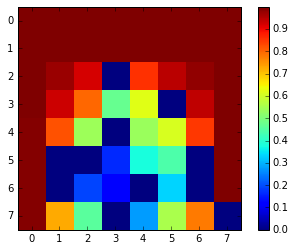

In [21]:
plt.imshow(optimal_value_func.reshape(8, 8), interpolation='nearest')
plt.colorbar()


- LEFT = 0
- DOWN = 1
- RIGHT = 2
- UP = 3

In [25]:
np.where(optimal_policy)[1].reshape((8,8))

array([[3, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 2],
       [0, 0, 0, 0, 2, 3, 3, 2],
       [0, 0, 0, 1, 0, 0, 2, 2],
       [0, 3, 0, 0, 2, 1, 3, 2],
       [0, 0, 0, 1, 3, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 0, 0, 1, 2, 1, 0]])

### Value Iteration Method
Value iteration method is very similar to the Policy Iteration method. The difference is we only do one iteration in the value function approximation. We also don't explicitly store the policy in the intermediate iterations and directly update the value function. The equations are given by
$$v_{k+1}(s) = \max\limits_{a} \sum_{s'} p(s' | s, a) (r(s', s, a) + v_k(s')).$$
This equation could also be thought of as an iteration of the simple iteration method for the Bellman equations for the optimal value function.
$$v_*(s) = \max\limits_{a} \sum_{s'} p(s' | s, a) (r(s', s, a) + v_*(s')).$$

In [22]:
def value_iteration(environment, maxiter=100, eps=1e-4):

    v = np.zeros((environment.nS,1))
    
    for i in range(maxiter):
        action_values = action_value(v, environment)
        v_new = np.max(action_values, axis=1)
        if np.max(np.abs(v_new - v)) < eps:
            print(i)
            break
        v = v_new
    policy = np.zeros((environment.nS, environment.nA))
    policy[np.arange(environment.nS), np.argmax(action_values, axis=1)] = 1
    return policy, v

In [23]:
optimal_policy, optimal_value_func = value_iteration(env, maxiter=400)

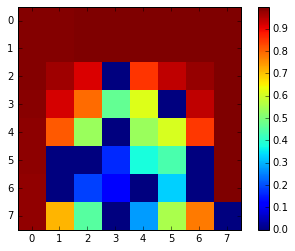

In [24]:
plt.imshow(optimal_value_func.reshape(8, 8), interpolation='nearest')
plt.colorbar()

Let us use the optimal policy on the actual task.

In [25]:
env = gym.make('FrozenLake8x8-v0')
# env = wrappers.Monitor(env, 'OptimalPolicy')
for i_episode in range(1):
    observation = env.reset()
    print(i_episode)
    for t in range(500):
        env.render()
        action = np.where(optimal_policy[observation])[0][0]
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.render()

INFO:gym.envs.registration:Making new env: FrozenLake8x8-v0
[2017-01-02 05:05:50,650] Making new env: FrozenLake8x8-v0


0
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FF

In [55]:
eps = 1/100.
eps_optimal_policy = np.copy(optimal_policy)
eps_optimal_policy[eps_optimal_policy == 0.] = eps
eps_optimal_policy[eps_optimal_policy == 1.] = 1 - 3 * eps

In [56]:
v = eval_policy(eps_optimal_policy, env, maxiter=1000, eps=1e-5)

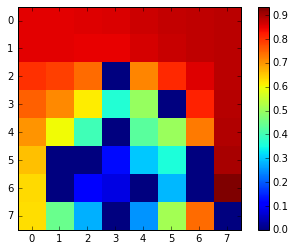

In [57]:
plt.imshow(v.reshape(8, 8), interpolation='nearest')
plt.colorbar()

In [58]:
v[0]

array([ 0.85412977])

In [59]:
np.save('../4_MC_TD/eps_opt_pi', eps_optimal_policy)
np.save('../4_MC_TD/eps_opt_v', v)

## Taxi-v1
https://gym.openai.com/envs/Taxi-v1

In [26]:
env = gym.make('Taxi-v1')

INFO:gym.envs.registration:Making new env: Taxi-v1
[2017-01-02 05:05:50,676] Making new env: Taxi-v1


In [27]:
optimal_policy, optimal_value_func = policy_iteration(env)

In [28]:
env = gym.make('Taxi-v1')
# env = wrappers.Monitor(env, 'OptimalPolicy')
for i_episode in range(1):
    observation = env.reset()
    print(i_episode)
    for t in range(500):
        env.render()
#         print(observation)
        action = np.where(optimal_policy[observation])[0][0]
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.render()

INFO:gym.envs.registration:Making new env: Taxi-v1
[2017-01-02 05:05:51,559] Making new env: Taxi-v1


0
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| :_: : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: |_: :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: 

In [30]:
12 * 25

300